In [1]:
from TimeSeries_impact.ts_analysis import tsa
from TimeSeries_impact import synthetic_ts
from TimeSeries_impact.ts_impact import impact_power

import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Time series analysis

In [2]:
data = synthetic_ts.make_time_series(200)
data["data"].iloc[100:120, 0] = None

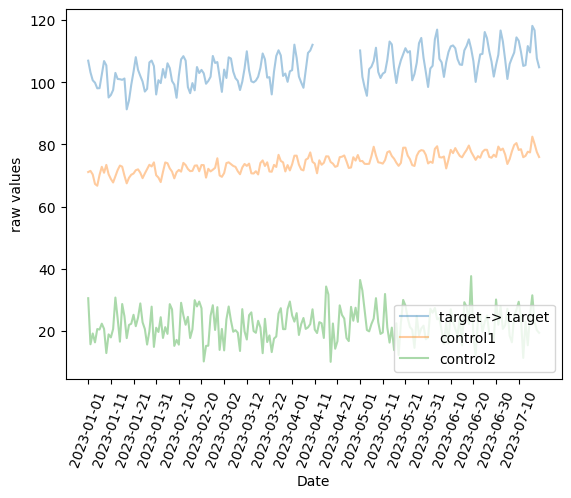

In [3]:
# check missing data
ts = tsa.TSA(data["data"])
ts.decompose()
ts.plot(with_trend=False, scaled=False)

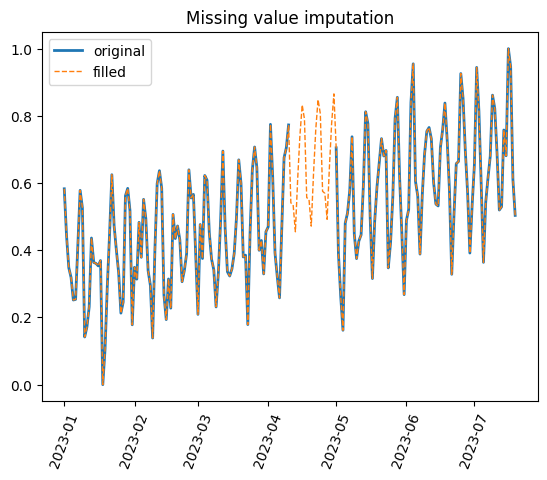

In [4]:
# fill in missing data
new_data = ts.fill_data(plot=True)

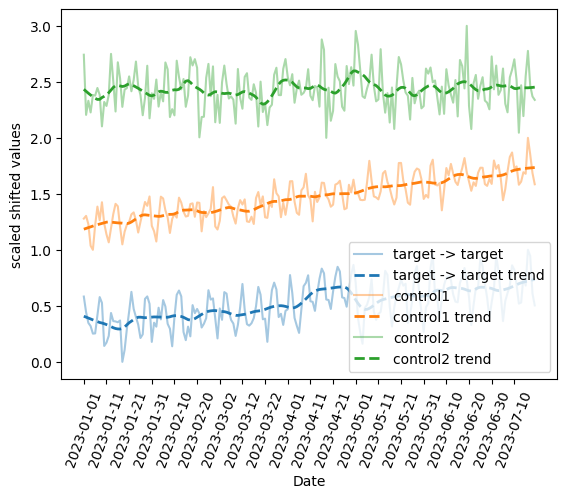

In [5]:

# plot
ts.plot(scaled=True, shifted=True, with_trend=True)


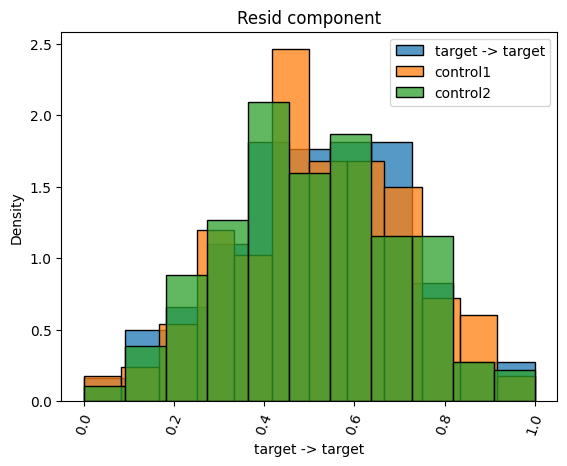

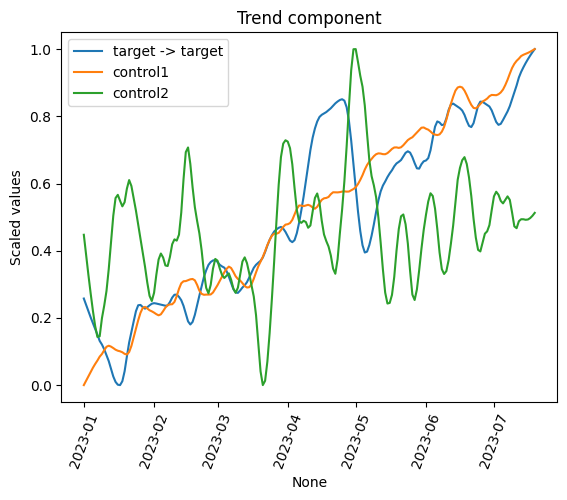

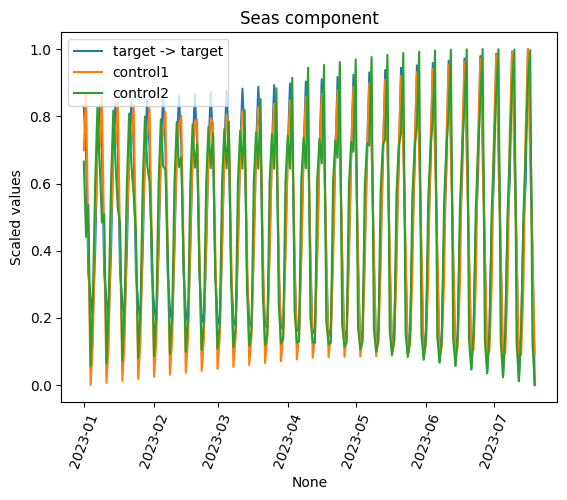

In [6]:
ts.plot_components()

In [7]:
res_simi, seas_simi = ts.get_components_similarity()
raw_simi = ts.get_data_similarity()
print(res_simi)
print()
print(seas_simi)
print()
print(raw_simi)

                           control1  control2
KL Divergence              0.266558  0.393099
Jensen-Shannon Divergence  0.042977  0.027728
Bhattacharyya Distance     0.047125  0.031742
MSE                        0.076327  0.074716
Cosine Similarity          0.875135  0.873816

     control1  control2
dtw  0.154024  0.115823

               control1      control2
euclidean  1.938629e+00  3.378729e+00
MAPE       2.449306e+06  1.383402e+07
pearson    7.762639e-01  2.977538e-01
dtw        6.780854e-03  9.616718e-03


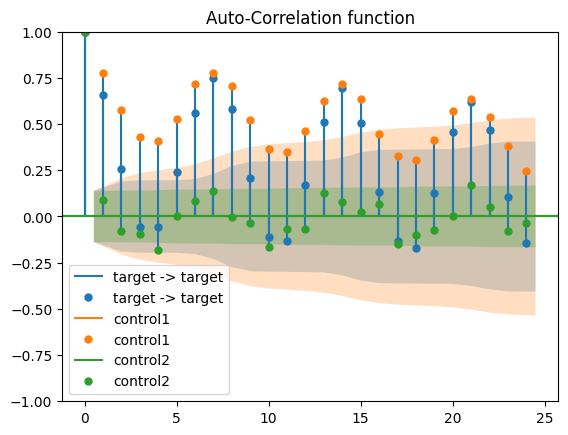

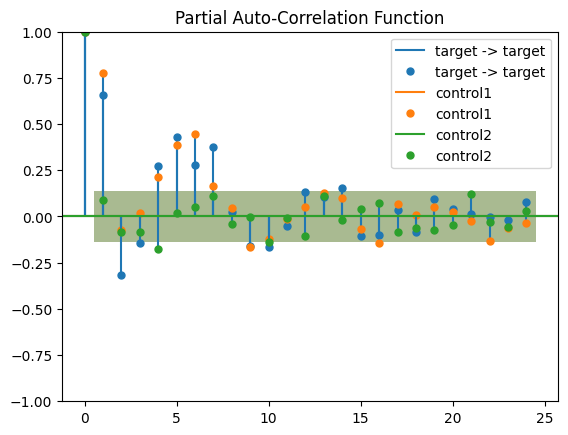

In [8]:
ts.plot_autocorrelation()

In [9]:
#ts.similarity_analyzer.plot_similarity_surface()

In [10]:
#opt_res = ts.optimize_decomposition()

# Power analysis and simulations

In [11]:
# replace missings
data["data"]["target"].iloc[:] = new_data 

In [12]:
imp = impact_power.SimImpact(data["data"])
imp_trend = impact_power.SimImpact(data["data"])

relup_list = np.linspace(0, 0.2, 10)
test_size = 30

imp.make_sim(relup_list, test_size)
imp_trend.make_sim(relup_list, test_size, on_trend=True, split_decomposition=True)

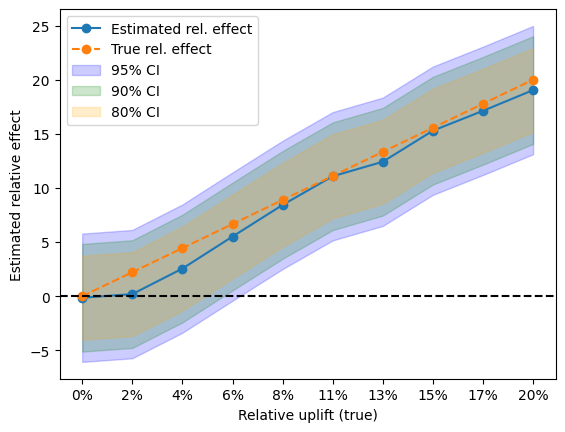

In [13]:
imp.plot_sim_rel()

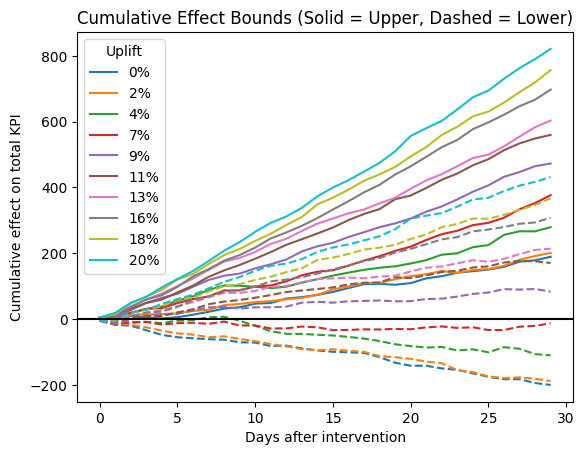

In [14]:
imp.plot_sim_cum()

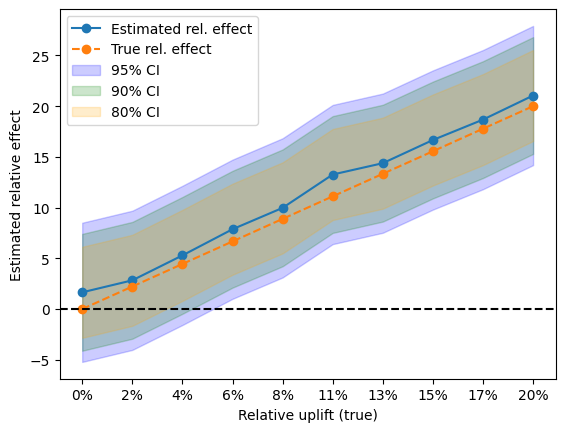

In [15]:
imp_trend.plot_sim_rel()

<Axes: >

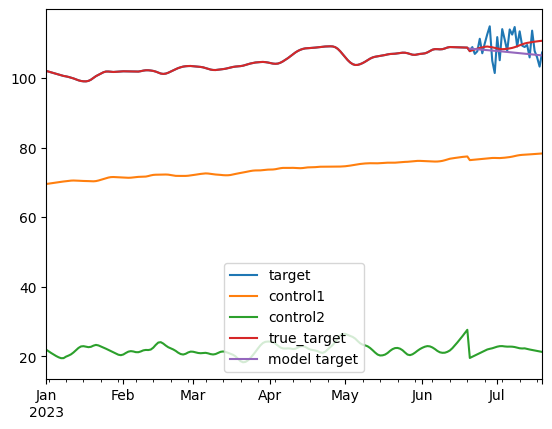

In [16]:
imp_trend.res_sim[0]["data"].plot()

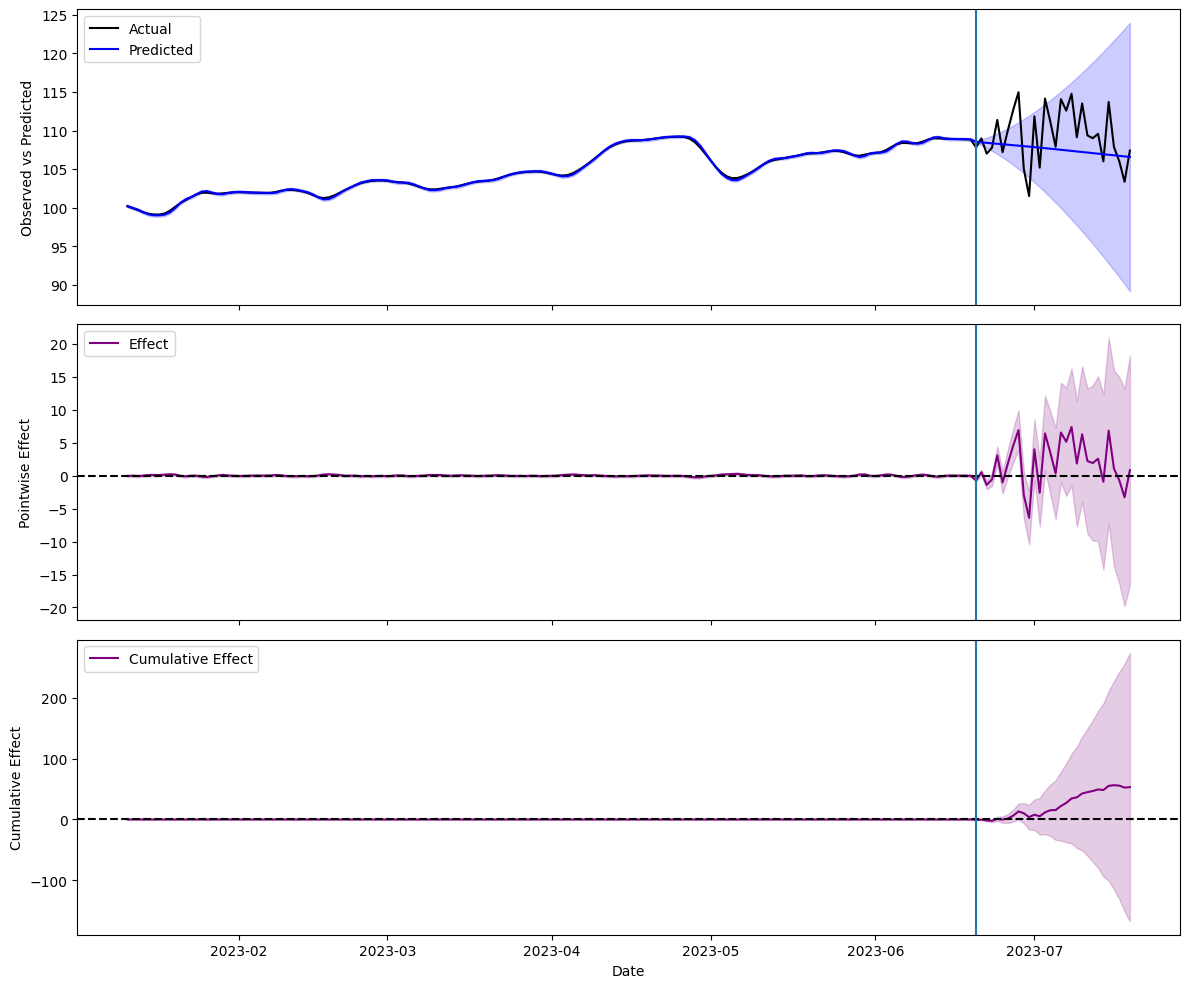

In [17]:
imp_trend.res_sim[0]["chart"]

In [ ]:
res_power = imp.power_analyse()

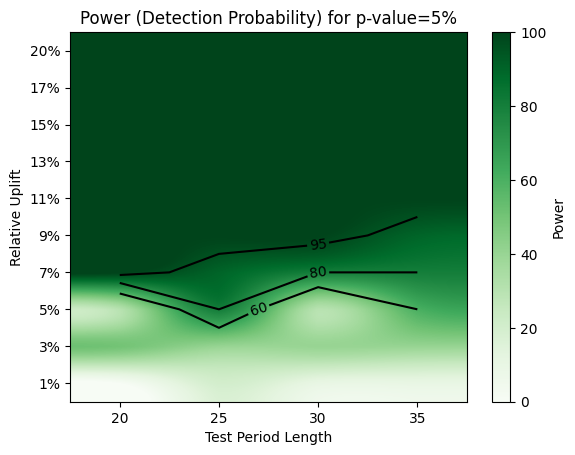

In [18]:
imp.plot_power(alpha=5)

# PyBats Backend

In [21]:
import pybats

In [23]:
from TimeSeries_impact.ts_impact import causal_impact_pybats

data_tmp = data["data"]
test_size = 30
pre_period = [data_tmp.index[0], data_tmp.index[-1 - test_size]]
post_period = [data_tmp.index[-test_size], data_tmp.index[-1]]

bats = causal_impact_pybats.CausalImpactBayes(data_tmp, pre_period, post_period)

In [24]:
bats.fit()

AttributeError: 'int' object has no attribute 'iloc'

# Classic causal impact with BSTS

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


2025-05-28 20:44:12.945028: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    128.82             6441.0
Prediction (s.d.)         106.04 (0.6)       5302.17 (29.89)
95% CI                    [104.89, 107.23]   [5244.51, 5361.68]

Absolute effect (s.d.)    22.78 (0.6)        1138.83 (29.89)
95% CI                    [21.59, 23.93]     [1079.33, 1196.5]

Relative effect (s.d.)    21.48% (0.56%)     21.48% (0.56%)
95% CI                    [20.36%, 22.57%]   [20.36%, 22.57%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 128.82. By contrast, in the absence of an
intervention, we would have expected an average response of 106.04.
The 95% interval of this counterfactual prediction is [104.89, 107.23].
Subtracting this prediction

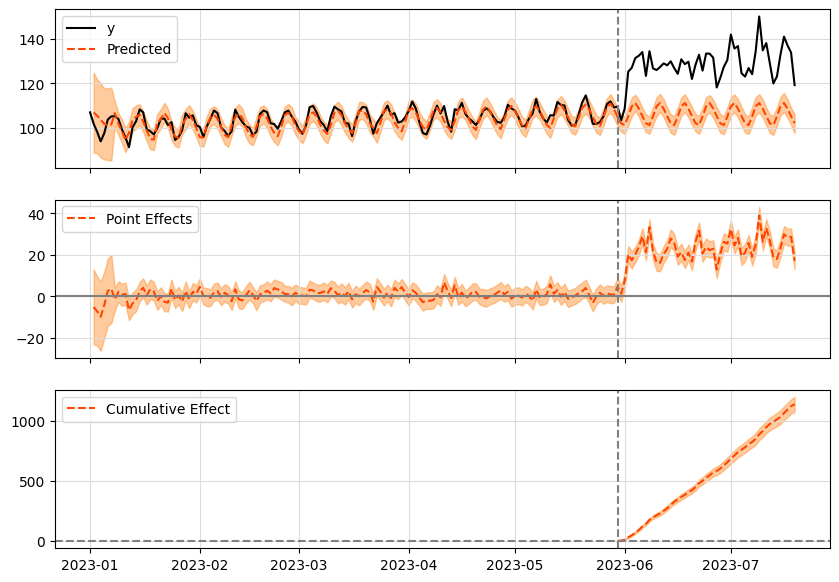

In [38]:
from TimeSeries_impact import utilities
from causalimpact import CausalImpact
import pandas as pd

# perform classic causalimpact with tfcausalimpact

data = synthetic_ts.make_time_series(200)

# add effect
relup = 0.2
uplift = relup*np.mean(data["data"]["target"])
target_with_effect = utilities.add_effect(data["data"]["target"], uplift, 50)

data["data"]["target"] = target_with_effect

pre_period = [data["data"].index[0], data["data"].index[149]]
post_period = [data["data"].index[150], data["data"].index[199]]

ci = CausalImpact(data["data"], pre_period, post_period, model_args={"nseasons":7})
print(ci.summary())
print(ci.summary(output='report'))
ci.plot()
